# Loading libraries and Data

In [38]:
#import datasets and load libraries
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import calendar



#import os
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,mean_absolute_percentage_error


from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import xgboost as xgb
import shap


#if i want to see output not truncated add this:df.infor()
pd.set_option('display.max_rows', None)   # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Prevent line wrapping
pd.set_option('display.max_colwidth', None) #show full column content

codes = pd.read_csv ('codes.csv')
df=pd.read_csv('USE_THIS.csv')

print(df.sample(100))
#looking good, theres negatives, all years, all months all good

              cc  subj  \
392515   L581600   159   
741395   L331100   156   
607211   L242102   117   
835266   L561300   432   
840655   L111600   152   
1271117  L131301   432   
544361   L121302   432   
1173474  L099000   112   
1026144  L331500   157   
551156   L580099   156   
1180435  L211450   152   
806003   L141301   431   
373297   L311301   432   
705630   L381302  3001   
605589   L091301   432   
527675   L111303   432   
534832   L611411   439   
1070004  L321300   436   
1440318  L571500   151   
1400954  L111600   152   
665840   L111301   432   
780780   L110099   157   
790754   L331301  3001   
222878   L381302   437   
1186640  L351300   432   
836319   L131302   432   
62935    S457051   432   
373235   L521300   432   
1065628  L099000  3001   
641257   L211502   152   
597602   L521200   151   
1659825  L091722   431   
1058233  L330099   156   
327230   L581301   432   
1071440  L581600   436   
1102098  L091723   437   
1358099  L530099   156   
930910   L51

In [39]:
#monthly totals for each month and year
# First, convert string values to float
df['payperiod'] = df['payperiod'].astype(float)

#then convert float to integer (now safe)
df['payperiod'] = df['payperiod'].astype(int)

amount_month= df.groupby(['year','payperiod'])['amount'].sum()
print(amount_month)

year  payperiod
2017  1            3,546,786.70
      2            3,703,645.09
      3            3,745,155.39
      4            4,446,153.29
      5            4,581,919.91
      6            4,866,646.79
      7            4,616,467.41
      8            4,761,501.96
      9            4,630,351.26
      10           4,776,823.93
      11           4,647,903.62
      12           4,516,723.99
2018  1            4,570,697.47
      2            4,736,929.73
      3            4,649,574.76
      4            4,531,284.31
      5            4,707,311.10
      6            4,579,976.52
      7            4,705,347.78
      8            4,570,931.43
      9            4,540,902.44
      10           4,709,102.13
      11           4,544,979.59
      12           6,413,624.90
2019  1            4,902,417.07
      2            4,893,473.38
      3            4,875,151.70
      4            4,931,352.37
      5            4,939,866.91
      6            4,871,709.61
      7            5,025

In [40]:
#drop reference and preiod columns
df.drop(columns=['reference', 'period', 'hours'], inplace=True)


In [41]:
#creating a propper date time column and fix april to be the 4th month instead of financial year
#first convert payperiod to int
df['fiscal_month'] = df['payperiod'].astype(int)

#convert fiscal month to calendar month
df['calendar_month'] = (df['fiscal_month'] + 3) % 12
df['calendar_month'] = df['calendar_month'].replace({0: 12}) # march becomes 0

# ajust year so everything happens in the same year
df['calendar_year'] = df['year']
df.loc[df['fiscal_month'] >= 10, 'calendar_year'] += 1

#create a datetime object. just the 1st of each month since there isnt a specific day
df['date'] = pd.to_datetime(df['calendar_year'].astype(str) + '-' + df['calendar_month'].astype(str) + '-01')


In [42]:
df.to_csv("continuous_data.csv", index=False)

In [43]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1725113 entries, 0 to 1725112
Data columns (total 12 columns):
 #   Column          Dtype         
---  ------          -----         
 0   cc              object        
 1   subj            int64         
 2   payrollgroup    object        
 3   payperiod       int64         
 4   element         object        
 5   job             object        
 6   year            int64         
 7   amount          float64       
 8   fiscal_month    int64         
 9   calendar_month  int64         
 10  calendar_year   int64         
 11  date            datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(6), object(4)
memory usage: 157.9+ MB
None


# SARIMA

SARIMA stands for Seasonal AutoRegressive Integrated Moving Average.
It is a statistical model used for forecasting time series data, especially when the data shows seasonal patterns (like yearly or monthly cycles).
- Good for interpretable, traditional time series forecasting.

- Handles both short-term fluctuations and repeating seasonal cycles.

In [44]:
#flagging covid years
df['date'] = pd.to_datetime(df['date']) #just to be xtra sure its in datetime

#flag COVID-affected dates
df['covid_flag'] = (
    (df['date'].dt.year == 2020) |
    ((df['date'].dt.year == 2022) & (df['date'].dt.month <= 9))
).astype(int)


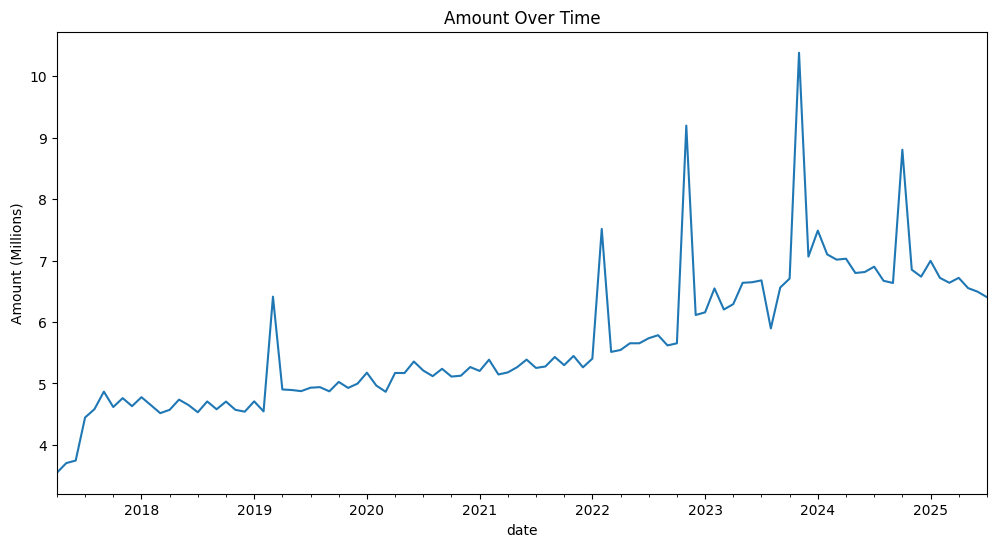

In [45]:

#graph showing amount over time
df_ts = df.groupby('date')['amount'].sum().sort_index()

(df_ts / 1e6).plot(title='Amount Over Time', figsize=(12,6))  #divided by 1e6 whihc means 1 000 000 (1 mil) so axis shows 1 2 3 
plt.ylabel('Amount (Millions)')
plt.show()



 ### SARIMA parameters
 (p, d, q) are the non-seasonal parameters:
 - p: number of lag observations included in the model (autoregressive part)
 - d: number of times the raw observations are differenced to make the series stationary
 - q: size of the moving average window (uses past forecast errors)

 (P, D, Q, s) are the seasonal parameters:
 - P: seasonal autoregressive order
 - D: seasonal differencing order
 - Q: seasonal moving average order
 - s: number of periods in each season (e.g. 12 for monthly data with yearly seasonality)



### manually tune SARIMA parameters:
to find out what d=
1. use plots to understand if the series is already stationary
2. plot the original series, and if the trend is removed after diff() then d=1. 
Now I need to find out p and q 

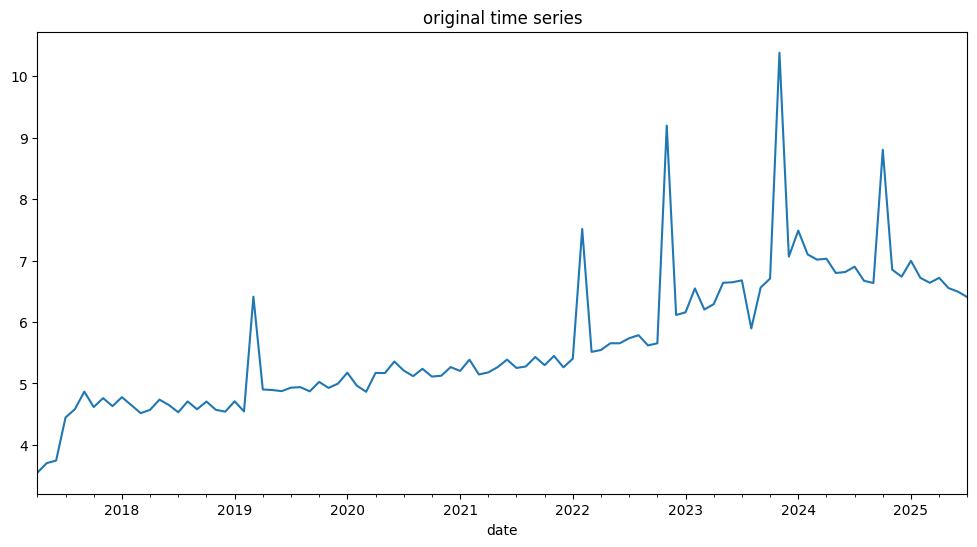

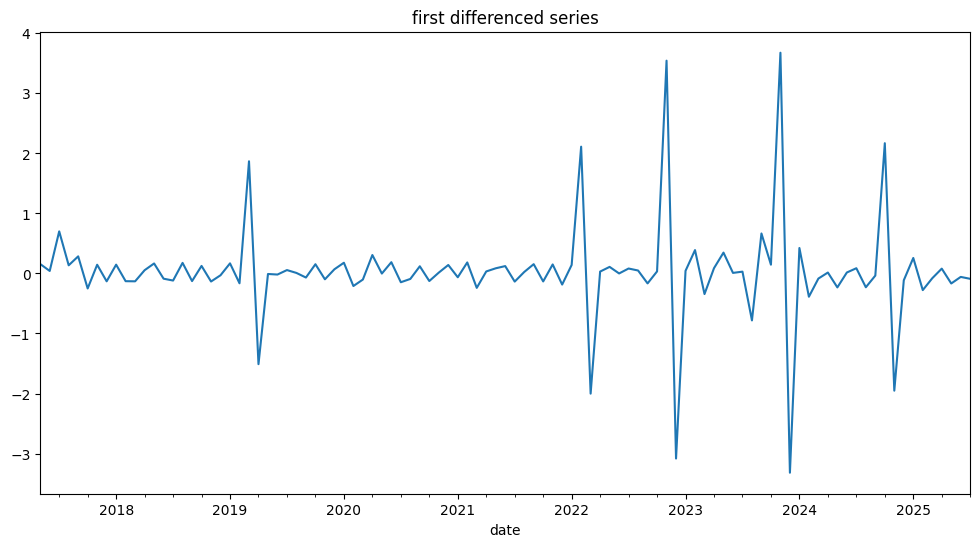

In [46]:
#use plots to understand if the series is already stationary by comparing orignial time series to first differenced
#plot the original series, if the trend is removed after .diff() then d = 1
(df_ts / 1e6).plot(title='original time series', figsize=(12,6))
plt.show()

#first difference (d=1), 
df_ts_diff = df_ts.diff().dropna()
(df_ts_diff / 1e6).plot(title='first differenced series', figsize=(12,6))
plt.show()


To find out what p and q are, use ACF and PACF plots

PACF spikes = good for estimating p

ACF spikes = good for estimating q



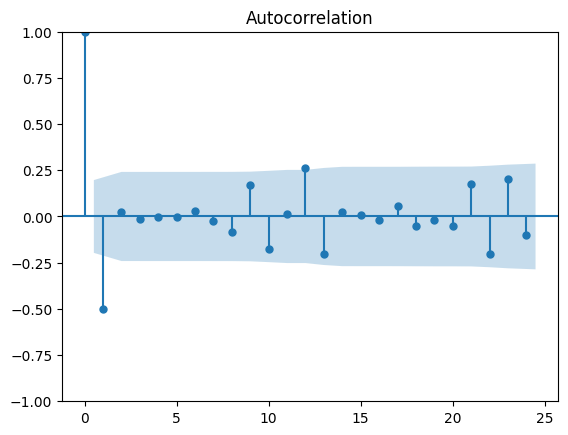

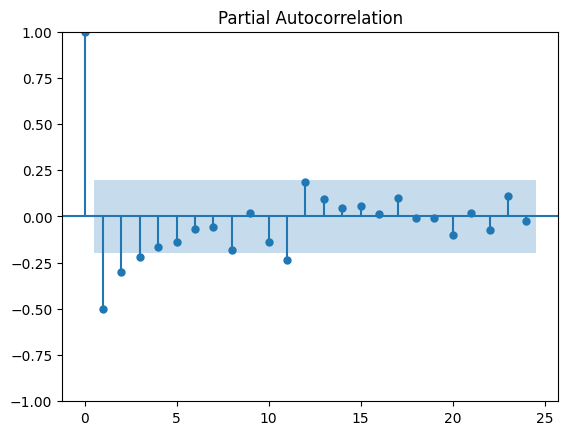

In [47]:
#autocorrelation(ACF) and partial autocorrelation (PACF) to find out p and q
#the 24 tells the function to shohw autocorrelations up to lag 20. 
#lag 24 covers short term dependencies (1-6 months) seasonal patterns (12 months) and longer term correlations (1+years)
plot_acf(df_ts_diff, lags=24) 
plot_pacf(df_ts_diff, lags=24)
plt.show()


It looks like in both graphs there are significantly non- zero sutocorrelations at lag 1
ACF (q) = 1

PACF (p) = 1
The data is monthly so s=12

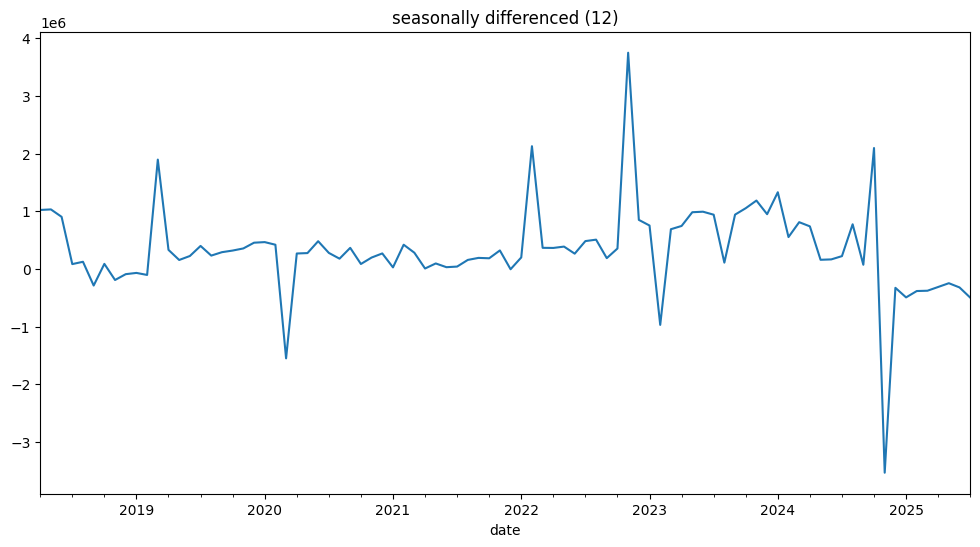

In [48]:
#plotting seasonal differences, If this removes repeating yearly patterns then d=1for sure
df_ts_seasonal_diff = df_ts.diff(12).dropna()
df_ts_seasonal_diff.plot(title='seasonally differenced (12)', figsize=(12,6))
plt.show()


It looks like repeating yearly patterns were removed so 

d = 1

p = 1

q = 1

s = 12
The lower the AIC the bettert the  fit

In [49]:
#using parameters 1,1,1    1,1,1,12
#worth trying with different combinations as well
model1 = SARIMAX(df_ts,
                order=(1,1,1), #(p, d, q) = non-seasonal ARIMA parameters
                seasonal_order=(1,1,1,12),  # (P, D, Q, s) = seasonal ARIMA parameters and s= length of the seasonal cycle in this case 12 moths
                enforce_stationarity=False,
                enforce_invertibility=False)

results1 = model1.fit()
print(results1.summary())



C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                             amount   No. Observations:                  100
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1092.649
Date:                            Thu, 04 Sep 2025   AIC                           2195.297
Time:                                    10:52:46   BIC                           2206.750
Sample:                                04-01-2017   HQIC                          2199.861
                                     - 07-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1684      0.259     -0.650      0.516      -0.676       0.339
ma.L1         -0.6965      0.193   

### tune SARIMA parameters with a loop

In [50]:
#loop to try different variations. 
for p in range(2):
    for q in range(2):
        for P in range(2):
            for Q in range(2):
                try:
                    model = SARIMAX(df_ts,
                                    order=(p,1,q),
                                    seasonal_order=(P,1,Q,12),
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
                    results = model.fit(disp=False)
                    print(f'ARIMA({p},1,{q}) x ({P},1,{Q},12) - AIC:{results.aic}')
                except:
                    continue


ARIMA(0,1,0) x (0,1,0,12) - AIC:2634.4837705260825
ARIMA(0,1,0) x (0,1,1,12) - AIC:2261.8135088000304


C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2k

ARIMA(0,1,0) x (1,1,0,12) - AIC:2301.0529088513053
ARIMA(0,1,0) x (1,1,1,12) - AIC:2261.559431997238
ARIMA(0,1,1) x (0,1,0,12) - AIC:2565.3863198721965
ARIMA(0,1,1) x (0,1,1,12) - AIC:2193.928716555002


C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2k

ARIMA(0,1,1) x (1,1,0,12) - AIC:2258.068595579355
ARIMA(0,1,1) x (1,1,1,12) - AIC:2194.851681824736
ARIMA(1,1,0) x (0,1,0,12) - AIC:2603.383193925798


C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2k

ARIMA(1,1,0) x (0,1,1,12) - AIC:2233.3970707429917
ARIMA(1,1,0) x (1,1,0,12) - AIC:2243.971216923079
ARIMA(1,1,0) x (1,1,1,12) - AIC:2233.741377745403


C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2k

ARIMA(1,1,1) x (0,1,0,12) - AIC:2565.6892794144123
ARIMA(1,1,1) x (0,1,1,12) - AIC:2194.3174891271246


C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2k

ARIMA(1,1,1) x (1,1,0,12) - AIC:2228.9086505183127
ARIMA(1,1,1) x (1,1,1,12) - AIC:2195.2974001901102


C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Best fit is   0,1,1    0,1,1,12

In [51]:
#best fit was so using those parameters (0,1,1)(0,1,1,12)
model1 = SARIMAX(df_ts,
                order=(0,1,1), #(p, d, q) = non-seasonal ARIMA parameters
                seasonal_order=(0,1,1,12),  # (P, D, Q, s) = seasonal ARIMA parameters and s= length of the seasonal cycle in this case 12 moths
                enforce_stationarity=False,
                enforce_invertibility=False)

results1 = model1.fit()
print(results1.summary())



C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                             amount   No. Observations:                  100
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1093.964
Date:                            Thu, 04 Sep 2025   AIC                           2193.929
Time:                                    10:52:48   BIC                           2200.800
Sample:                                04-01-2017   HQIC                          2196.667
                                     - 07-01-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7353      0.146     -5.027      0.000      -1.022      -0.449
ma.S.L12      -0.5254      0.059   

### SARIMA Forecast

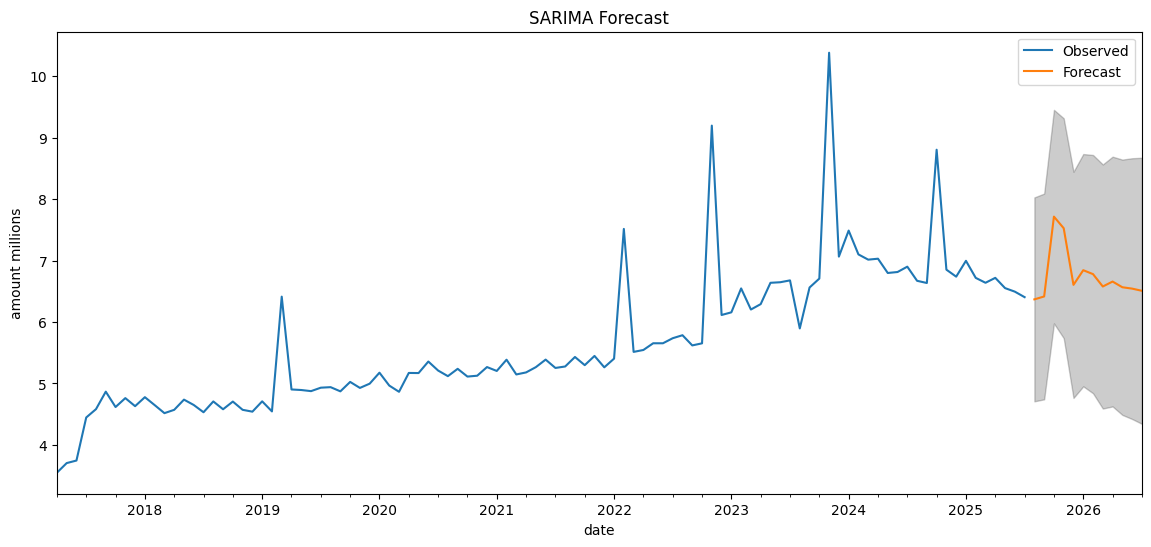

In [52]:
#forecast the next 12 months
pred = results.get_forecast(steps=12)
pred_ci = pred.conf_int()

#plot
ax = (df_ts / 1e6).plot(label='Observed', figsize=(14, 6))
(pred.predicted_mean / 1e6).plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0] / 1e6, 
                pred_ci.iloc[:, 1] / 1e6, 
                color='k', alpha=0.2)
ax.set_title('SARIMA Forecast')
ax.set_ylabel ('amount millions')
plt.legend()
plt.show()


# XGBoost


XGBoost builds a series of decision trees, where each tree tries to correct the mistakes made by the previous ones.

1. Start with a simple prediction (e.g., average of all target values).

2. Measure the errors (residuals) between predicted and actual values.

3. Build a small decision tree to predict these errors.

4. Update the prediction by adding the new tree's output (a correction).

5. Repeat steps 2–4, adding one tree at a time, gradually improving the model.

6. Stop when a set number of trees is reached or performance stops improving.

Each tree is 'boosted' by learning from the previous ones — hence gradient boosting.- Very accurate and fast.


### Preprocessing

1. add the CC and IJB budget page df and change names
2. one hot encode the IJB budget pages
3. flagging months with peaks
4. encode categorical variables

addding CC and ijb budget pages

In [53]:
# clean and standardize cost center codes
codes = codes.rename(columns={'CC': 'cc', 'IJB Budget Page': 'ijb_budget_page'})
codes['cc'] = codes['cc'].astype(str).str.strip().str.upper()
codes = codes.drop_duplicates('cc')

#merge ijb budget page onto df.
df['cc'] = df['cc'].astype(str).str.strip().str.upper()
df = df.merge(codes[['cc', 'ijb_budget_page']], on='cc', how='left', validate='many_to_one')

# captrue the unique ijb budget levels
budget_levels = sorted(codes['ijb_budget_page'].dropna().unique())


One hot encoding for ijb budgets pages

In [54]:
# making amillione columns with one hot encoder for ijb budget page
#yay
def add_budget_page_ohe(frame, levels):
    if 'ijb_budget_page' not in frame.columns:
        return frame
    out = frame.copy()
    cat = pd.Categorical(out['ijb_budget_page'], categories=levels)
    dummies = pd.get_dummies(cat, prefix='ijb_budget_page', dummy_na=False).astype('uint8')
    out = pd.concat([out.drop(columns=['ijb_budget_page']), dummies], axis=1)
    return out

flagging months with peaks

In [55]:
# set large payment months and build a month start flag.
flag_months = ['2022-11', '2023-11', '2024-10', '2025-09']
flag_starts = pd.to_datetime([m + '-01' if len(m) == 7 else m for m in flag_months])

df = df.copy()
df['date'] = pd.to_datetime(df['date'])
df['month_start'] = df['date'].values.astype('datetime64[M]')
df['large_payment_flag'] = df['month_start'].isin(flag_starts).astype('uint8') #booleans fo is in flagged month 

print("flag counts (historical):", df['large_payment_flag'].value_counts().to_dict())


flag counts (historical): {0: 1616502, 1: 108611}


Encoding Categorical Variables

In [56]:
# encode categoricals with label encoder
categorical_cols = ['cc', 'payrollgroup', 'element', 'job']
label_encoders = {}
inv_mappings = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    inv_mappings[col] = {v: k for k, v in dict(zip(le.classes_, le.transform(le.classes_))).items()}


### Train/Test Split


splits dataset into training and test sets for both features = x and target = y

parameters:
- x = feature matrix (input data)
- y = target vector (what i want to predict)
- test_size=0.2 = reserves 20% of the data for testing
- random_state=42 = ensures reproducible split

Output:
- X_train, y_train = used to train the model
- x_test, y_test = used to evaluate the model

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1725113 entries, 0 to 1725112
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   cc                  int64         
 1   subj                int64         
 2   payrollgroup        int64         
 3   payperiod           int64         
 4   element             int64         
 5   job                 int64         
 6   year                int64         
 7   amount              float64       
 8   fiscal_month        int64         
 9   calendar_month      int64         
 10  calendar_year       int64         
 11  date                datetime64[ns]
 12  covid_flag          int64         
 13  ijb_budget_page     object        
 14  month_start         datetime64[s] 
 15  large_payment_flag  uint8         
dtypes: datetime64[ns](1), datetime64[s](1), float64(1), int64(11), object(1), uint8(1)
memory usage: 199.1+ MB


In [58]:
# build time features then add budget page one hots.
# pull standard calendar parts to support both calendar and fiscal 
df['calendar_year'] = df['date'].dt.year
df['calendar_month'] = df['date'].dt.month


# fixing fiscal months to calendar months
# shift months back by 3 so apr becomes 1 and wrap around to 12
df['fiscal_month'] = (df['date'].dt.month - 3) % 12
df['fiscal_month'] = df['fiscal_month'].replace({0: 12})

# label the fiscal year as the same calendar year for apr to dec 
df['year'] = np.where(df['date'].dt.month > 3, df['date'].dt.year, df['date'].dt.year - 1)

# mirror of fiscal month for code that expects payperiod
df['payperiod'] = df['fiscal_month']


In [59]:
# makning covid flag
df['covid_flag'] = ((df['date'].dt.year == 2020) | ((df['date'].dt.year == 2022) & (df['date'].dt.month <= 9))).astype(int)



In [60]:
# time is a circle
# cyclic month features
# encode month on a circle so december and january are close 
df['mo_sin'] = np.sin(2 * np.pi * df['calendar_month'] / 12.0)
df['mo_cos'] = np.cos(2 * np.pi * df['calendar_month'] / 12.0)



In [61]:
# add ijb budget page one hots.
# expand categorical page into consistent dummy columns using fixed levels so train and future align.
df = add_budget_page_ohe(df, budget_levels)


In [62]:
# drop helper date columns not used for modeling.
for col in ['month_start', 'month_period']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)



Defining features to exclude the target (amount) and date

In [63]:
# define feature list excluding target and raw date.
# leave out amount because it is the target and date because we use derived parts instead.
features = [c for c in df.columns if c not in ['amount', 'date']]


In [64]:
# making things sturdier
# remove duplicated column names to avoid weird inputs at fit time.
dupe_cols = df.columns[df.columns.duplicated()].tolist()
if dupe_cols:
    print("Dropping duplicated columns:", dupe_cols)
    df = df.loc[:, ~df.columns.duplicated(keep='first')]

# keep only features that still exist
features = [c for c in features if c in df.columns]

#  numeric inputs only
# convert any remaining non numeric feature columns to category codes as a safe net
bad = df[features].select_dtypes(exclude=['number', 'bool']).columns.tolist()
for col in bad:
    print(f"Converting {col} from {df[col].dtype} to category codes")
    df[col] = pd.Categorical(df[col]).codes

# ensure each feature name is present once
features = list(dict.fromkeys(features))


What’s left becomes the input features (X) - like cc, subj, month etc

splitting **training data**
- x_train = input features for the model to learn from
- y_train = the known historical target values (amounts),  used to train the model

splitting **test data** 
- x_test = inputs for the future/prediction period
- y_test = actual values for this futre period (used to evaluate model performance)

SOOOO
- the model learnspatterns from x_train to predict y_train 
- then it makes predictions on x_test
- ten compare those predictions with y_test to see how well it performs

In [65]:
# train test split by date.
train_df = df[df['date'] < '2024-07-01'].copy()
test_df = df[df['date'] >= '2024-07-01'].copy()

X_train, y_train = train_df[features], train_df['amount']
X_test, y_test = test_df[features], test_df['amount']

# checkin that everything is numerrrrric
print("Nonnumeric features:", X_train.select_dtypes(exclude=['number', 'bool']).columns.tolist()) 


Nonnumeric features: []


### Training the model

| Parameter            | What It Does                                                                 | Effect with Large Data                                     | Suggested Value(s)           |
|----------------------|------------------------------------------------------------------------------|-------------------------------------------------------------|-----------------------------|
| `n_estimators`       | Number of boosting rounds (trees)                                            | More trees = better accuracy, but longer training           | 100–500 (start with 100) go up to 350 if performance is low   |
| `max_depth`          | Maximum depth of each tree (model complexity)                                | Higher = more patterns learned, but overfitting risk        | 4–8 (start with 6)          |
| `learning_rate`      | Shrinks the contribution of each tree (step size)                            | Lower rate = slower learning, but better generalization     | 0.05–0.1 is good for large data                    |
| `subsample`          | Percentage of rows used per tree (row sampling)                              | Helps prevent overfitting by using partial data per tree    | use 0.8 or 0.7 to prevent overfitting        |
| `colsample_bytree`   | Percentage of features used per tree (column sampling)                       | Reduces overfitting by ignoring some features each tree     | 0.7–0.9          |
| `n_jobs`             | Number of CPU cores to use for training                                      | Controls parallelism — more cores = faster training         | -1 (use all CPU cores)      |
| `tree_method`        | The algorithm XGBoost uses to grow trees                                     | Faster tree-growing methods help with big data              | 'hist' or 'gpu_hist'        |
| `random_state`       | Sets a fixed seed for reproducibility                                        | Doesn’t affect performance but ensures consistent results   | Any integer (e.g., 42)  for faster training on large data     |
| `early_stopping_rounds` | Stops training if no improvement on validation set after N rounds         | Speeds up training and prevents overfitting                 | 10–20 with `eval_set` used  |


In [66]:
# xgboost model parameters.
model = xgb.XGBRegressor(
    n_estimators=350,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.7,
    colsample_bytree=0.8,
    n_jobs=-1,
    tree_method='hist',
    random_state=42
)

# fit and make test prediction
model.fit(X_train, y_train)
test_pred = model.predict(X_test)

#checking that flags are being used
print('flag in features?', 'large_payment_flag' in features)
print('train flag counts:', train_df['large_payment_flag'].value_counts().to_dict())


flag in features? True
train flag counts: {0: 1422022, 1: 76239}


### SHAP

SHAP (SHapley Additive exPlanations ) is a method to explain the output of machine learning models by assigning each feature an importance value for a particular prediction 

For each prediction, SHAP assigns each feature a value that shows how much it pushed the prediction higher or lower compared to the baseline (average prediction)



In [67]:
#SHAP

X_eval = X_test[features].copy()  # use test se
X_eval = X_eval.sample(min(3000, len(X_eval)), random_state=42)
X_eval = X_eval.fillna(0)


explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_eval)


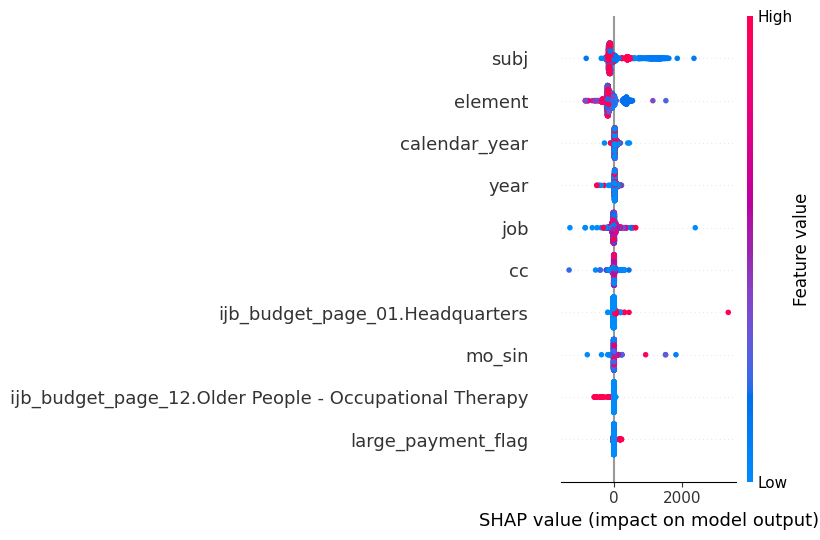

In [68]:

# plot of impactful features
shap.summary_plot(shap_values, X_eval, plot_type='dot', max_display=10, show=True)


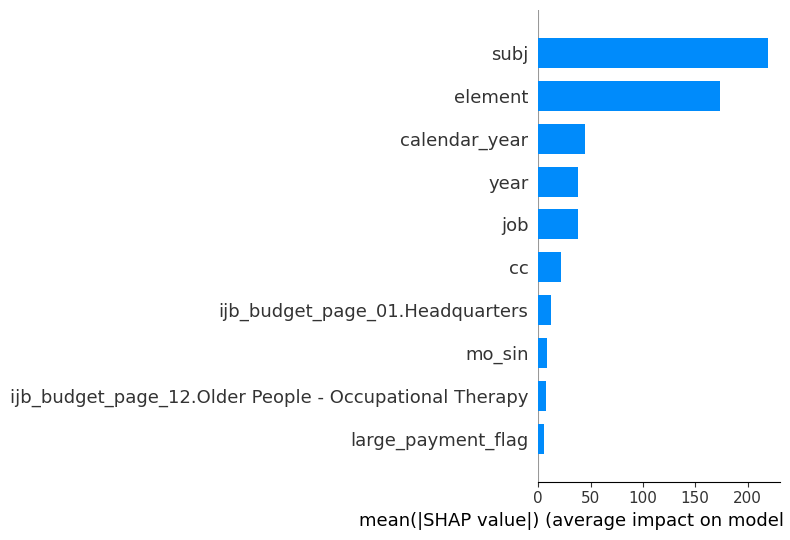

In [69]:

# bar graph of most impactful features
shap.summary_plot(shap_values, X_eval, plot_type='bar', max_display=10, show=True)


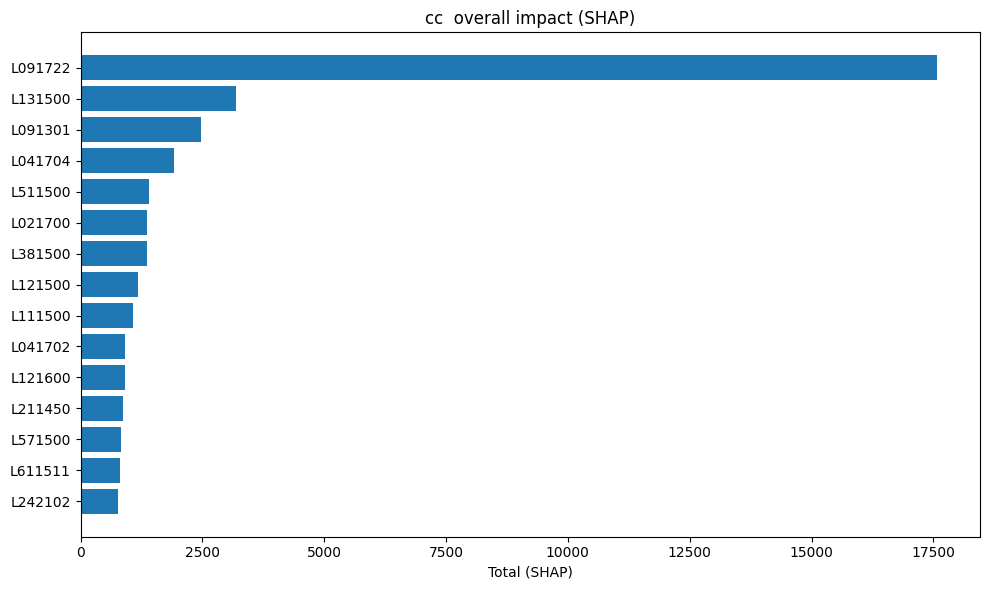

     cc   n  total_abs_SHAP  mean_abs_SHAP  mean_SHAP  share_%
L091722 284       17,578.99          61.90     -61.52    26.88
L131500  79        3,183.53          40.30     -35.26     4.87
L091301 197        2,461.85          12.50       7.16     3.76
L041704  19        1,921.53         101.13     100.57     2.94
L511500 139        1,409.36          10.14       9.61     2.16
L021700   8        1,363.03         170.38     170.38     2.08
L381500 139        1,356.55           9.76       7.75     2.07
L121500  71        1,170.05          16.48      16.10     1.79
L111500  68        1,067.55          15.70      14.91     1.63
L041702   7          920.59         131.51     131.51     1.41
L121600  52          906.32          17.43     -14.15     1.39
L211450  34          868.68          25.55     -25.54     1.33
L571500  66          827.64          12.54      11.85     1.27
L611511  66          816.26          12.37     -12.13     1.25
L242102  15          767.72          51.18      51.18  

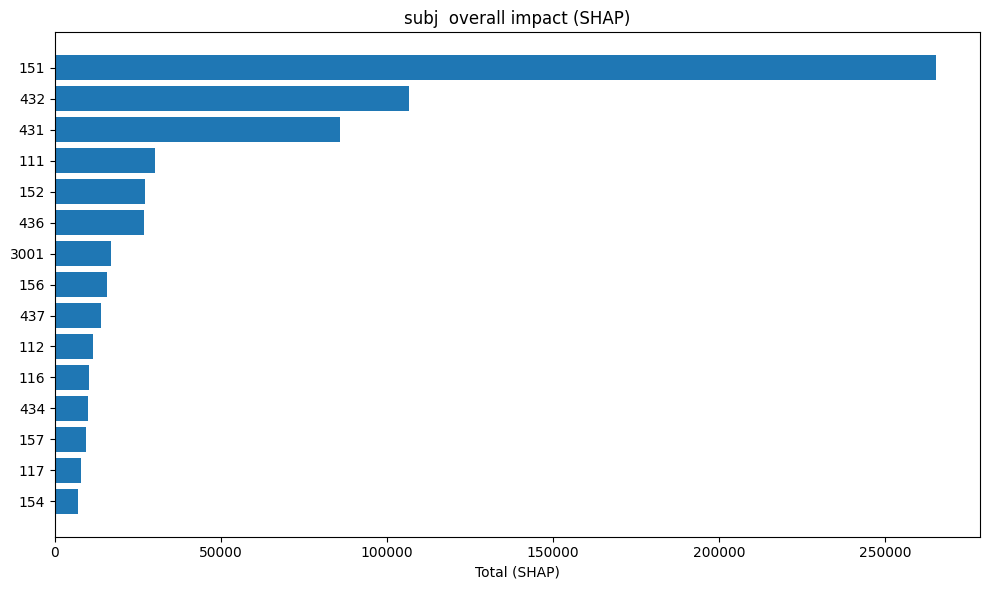

 subj   n  total_abs_SHAP  mean_abs_SHAP  mean_SHAP  share_%
  151 218      265,406.41       1,217.46   1,217.46    40.22
  432 795      106,648.59         134.15    -134.15    16.16
  431 210       86,003.84         409.54     409.54    13.03
  111  37       30,316.10         819.35     819.35     4.59
  152 236       27,089.23         114.78     -93.55     4.10
  436 209       26,801.43         128.24    -128.24     4.06
 3001 124       16,866.95         136.02    -136.02     2.56
  156 204       15,762.78          77.27     -72.79     2.39
  437 261       13,755.25          52.70     -52.65     2.08
  112  82       11,548.42         140.83    -140.83     1.75
  116  64       10,202.94         159.42    -159.42     1.55
  434  79       10,033.88         127.01    -127.01     1.52
  157 248        9,417.29          37.97      20.84     1.43
  117  63        7,877.04         125.03    -125.03     1.19
  154  57        6,887.47         120.83    -120.83     1.04


In [70]:

#drill down into cc and subj
# ensure there is a numoy array of shap values aligned with X_eval
_sv = shap_values.values if hasattr(shap_values, 'values') else shap_values

#shap df where columns match X_eval features and rows align to its observations
shap_df = pd.DataFrame(_sv, columns=X_eval.columns, index=X_eval.index)


#summary graph with shap impact stats on CC
def shap_drilldown(col, pretty=None, top=15):
    #Aggregate SHAP for one categorical feature by its category values
    if col not in X_eval.columns or col not in shap_df.columns:
        print(f'{col} not in features; skipping.')
        return pd.DataFrame()

    contrib = shap_df[col].values #get shap info from column
    cats    = X_eval[col].values #get raw category (cats) codes for the column

    #aggrefated cats summary table
    tbl = (pd.DataFrame({col: cats, 'shap': contrib})
           .groupby(col) #group rows by feature category
           .agg(n=('shap','size'),
                total_abs_SHAP=('shap', lambda x: np.abs(x).sum()),
                mean_abs_SHAP=('shap', lambda x: np.abs(x).mean()),
                mean_SHAP=('shap','mean'))
           .reset_index())

    #calculating each cat share of shap importancwe
    total_abs = np.abs(contrib).sum()
    tbl['share_%'] = 100.0 * tbl['total_abs_SHAP'] / (total_abs if total_abs > 0 else np.nan)

    #to rename
    name_col = pretty or col
    tbl.rename(columns={col: name_col}, inplace=True)

    # unencode names and if it fails just leaving them as they are
    if 'inv_mappings' in globals() and col in inv_mappings:
        tbl[name_col] = tbl[name_col].map(inv_mappings[col]).fillna(tbl[name_col])
    elif 'label_encoders' in globals() and col in label_encoders:
        try:
            tbl[name_col] = label_encoders[col].inverse_transform(tbl[name_col].astype(int))
        except Exception:
            pass

    # rank by overall impact and keep top N
    tbl = tbl.sort_values('total_abs_SHAP', ascending=False).head(top)

    # horizontal bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(tbl[name_col].astype(str)[::-1], tbl['total_abs_SHAP'][::-1])
    plt.xlabel('Total (SHAP)')
    plt.title(f'{name_col}  overall impact (SHAP)')
    plt.tight_layout()
    plt.show()

    # summary table
    print(tbl[[name_col, 'n', 'total_abs_SHAP', 'mean_abs_SHAP', 'mean_SHAP', 'share_%']].to_string(index=False))
    return tbl

# Run for cc and subj
cc_impact   = shap_drilldown('cc',   pretty='cc',   top=15)
subj_impact = shap_drilldown('subj', pretty='subj', top=15)


### Forecasting



1. A helper _month_start makes sure any date or timestamp is snapped to the first day of that month.

2. A helper _ensure_encodings_inplace checks if label encoders exist and, if so,  applies them to any object-type columns in a DataFrame so categories are turned into numeric codes.

3. A helper _add_date_features takes a dataset and a chosen future month, then stamps that month onto every row and rebuilds all the date-related features (calendar year, fiscal month, pay period, COVID flag, sine/cosine month cycle).

4. A helper _to_month_start is used to clean and normalize input dates (including blanks or nulls) to the first of the month.

5. The function prepare_future_adjustments_from_table reads a table of adjustment rules (like manual overrides or fixed amounts) and converts it into a standard list of dictionaries that the forecasting function can use.

6. Inside this function, it keeps only active rules, cleans up the start and end dates, and fills in missing columns (kind, value) if they’re not present.

7. For each row, it determines whether the rule applies globally or to a specific cost centre, encoding CC IDs if needed.

8. It figures out whether the adjustment is an absolute amount, an additive adjustment, or a legacy percent, and extracts the correct value.

9. It collects all valid rules into a list of dictionaries with the same keys (start, end, cc_enc, kind, value) and returns that list for use in forecasting.


In [71]:
# snap any timestamp to the first day of its month
def _month_start(ts):
    ts = pd.to_datetime(ts)
    return pd.Timestamp(ts.year, ts.month, 1)
# apply fitted label encoders to object columns
def _ensure_encodings_inplace(df_like, encoders):
    if not encoders:
        return df_like
    # only transform columns that exist and are object dtype
    for col, le in encoders.items():
        if col in df_like.columns and df_like[col].dtype == 'O':
            df_like[col] = le.transform(df_like[col].astype(str))
    return df_like


In [72]:
# stamp a single future month onto a copy and rebuild date features to match training.
def _add_date_features(frame, future_month_start):
    #  timestamp representing the first of the month
    fm = pd.Timestamp(future_month_start)
    # fiscal month with april as month one
    fiscal_month = (fm.month - 3) % 12 or 12
    # work on a copy 
    out = frame.copy()
    # set the date to the future month for all rows
    out['date'] = fm
    # basic calendar parts
    out['calendar_year'] = fm.year
    out['calendar_month'] = fm.month
    # fiscal month and related tags
    out['fiscal_month'] = fiscal_month
    out['year'] = fm.year if fm.month > 3 else fm.year - 1
    out['payperiod'] = fiscal_month
    # covid period marker
    out['covid_flag'] = int((fm.year == 2020) or ((fm.year == 2022) and (fm.month <= 9)))
    # redo cyclic month features
    if 'mo_sin' in out.columns and 'mo_cos' in out.columns:
        out['mo_sin'] = np.sin(2 * np.pi * out['calendar_month'] / 12.0)
        out['mo_cos'] = np.cos(2 * np.pi * out['calendar_month'] / 12.0)
    
    return out


In [73]:
# helpers to read/normalise/encode the adjustments table 
def _to_month_start(x):
    if x is None or (isinstance(x, float) and pd.isna(x)) or (isinstance(x, str) and not x.strip()):
        return None
    ts = pd.to_datetime(x)
    return pd.Timestamp(ts.year, ts.month, 1)

def prepare_future_adjustments_from_table(adj_df, label_encoders=None):

    #normalises adjustments into a list of dicts the forecast function understands

    def _to_month_start(v):
        if v is None or (isinstance(v, float) and pd.isna(v)) or (isinstance(v, str) and v.strip() == ''):
            return None
        ts = pd.to_datetime(v)
        return pd.Timestamp(ts.year, ts.month, 1)

    df = adj_df.copy()

    # keep only active rows
    if 'active' in df.columns:
        df = df[df['active'] == True].copy()

    # parse dates
    df['start'] = df['start'].apply(_to_month_start)
    if 'end' in df.columns:
        df['end'] = df['end'].apply(_to_month_start)
    else:
        df['end'] = None

    # normalies missing columns
    if 'kind' not in df.columns:
        df['kind'] = np.nan
    if 'value' not in df.columns:
        df['value'] = np.nan

    out = []
    le_cc = (label_encoders or {}).get('cc')

    for _, r in df.iterrows():
        # figure out scope -> cc_enc
        scope = str(r.get('scope', '')).lower()
        key = r.get('key', None)

        if scope == 'global':
            cc_enc = None
        elif scope == 'cc':
            if le_cc is not None:
                # only transform if key exists in encoder. else skip
                try:
                    cc_enc = le_cc.transform([key])[0]
                except Exception:
                    # unknown CC label - skip this row
                    continue
            else:
                # no encoder provided - skip CC rule
                continue
        else:
            continue

        # determine kind/value
        kind = str(r.get('kind', '')).strip().lower()
        val = r.get('value', np.nan)

        if kind in ('amount', 'adjustment'):
            try:
                value = float(val)
            except Exception:
                continue
        else:
            # #fix percentage problem from before 
            if 'pct' in df.columns and pd.notna(r.get('pct', np.nan)):
                kind = 'percent'
                try:
                    value = float(r['pct'])  # 0.10 is 10%
                except Exception:
                    continue
            else:
                
                continue

        out.append({
            'start': r['start'],
            'end': r['end'],
            'cc_enc': cc_enc,
            'kind': kind,     
            'value': value,   # absolute for amount/adjustment and fraction for percent
        })

    return out



This very long function forecasts the next N months by reusing the exact set of row tthat existed in the dame month last year (the panel), only updating the date fields and then running the trained model to get row by row predictions. it then sums those row predictinos to monthly totals and adds some checks.

step by step:

1. inputs
- df: all historical data (must include date and amount)

- model: the trained XGBoost 

- features: the exact columns the model expects (everything that it has been trained on, excluding amount and date).

- horizon_months: how many months to forecast

- start_from: last historical month to anchor the forecast (defaults to the last month in df)

- label_encoders: dict for turning categorical strings into the same codes used in training

- drift_rate_per_month:  grow/shrink the panel size a little each month (e.g., +3%)

- trend_scaling: can apply a gentle year-over-year scaling factor learned from history

- trend_clip: caps that YoY factor so it can’t swing wildly

- warn_tolerance: if the future panel size differs too much from the base month, adds a warning note.

2. Set up. data is copied and definitely datetime. builds a list of future months (1st of each month)

3. when trend scaling=true then do some math stuff that nudges predictions up/down a bit for realism

4. forecast loop (once per each future month)
- Pick the base panel: take all rows from the same month last year. If that’s empty, fall back to the previous month. If still empty, skip this month and record a note.

- Optional drift: if drift_rate_per_month ≠ 0, randomly duplicate (growth) or drop (decline) some rows to simulate headcount/mix drift.

- Update time features: call _add_date_features(base_rows, fm) to rewrite date-based columns (e.g., calendar/fiscal month, year, etc.) to the future month.

- Remove target: drop amount so it doesnt leak the answer into the model.

- Encode categoricals (if needed): _ensure_encodings_inplace applies the saved label encoders so category codes match training.

- Align features: reindex(columns=features, fill_value=0) ensures the prediction frame has exactly the same columns the model expects (adds any missing as 0, drops extras).

- Predict per row: model.predict(X_future) returns a prediction for each row in the panel.

-  trend scaling: if enabled, multiply those predictions by the YoY factor for the base month (capped to trend_clip).

- Store results: save the row-level predictions with the future month_start. Record diagnostics about panel sizes and any warnings.

5. aggregate and return
 - concatenates all row evel predictions into future_detail
 - sums by month_start to get future_monthyl['predicted toatal']
 - merge in the diagnostics 
 - return
    - future_detial : every predicted row for every future month
    - one row per month with the total forecast and sanity check info
 


In [74]:
# forecast engine using same month last year with full panel swaps
def forecast_same_month_last_year(
    df_hist,
    model,
    features,
    horizon_months=12,
    start_from=None,
    label_encoders=None,
    drift_rate_per_month=0.0,
    trend_scaling=False,
    trend_clip=(0.9, 1.1),
    random_state=42,
    warn_tolerance=0.15,
    full_panel_swaps=None,
    add_budget_page_ohe_fn=None,
    budget_levels=None,
    flag_starts=None,
    future_adjustments=None,   
):                         

    # make a working copy and ensure date is datetime.
    dfh = df_hist.copy()
    dfh['date'] = pd.to_datetime(dfh['date'])

    #choose the anchor month as the last month present if its not there
    if start_from is None:
        start_from = _month_start(dfh['date'].max())


    #normalised map of future month to source month for full panel swaps
    swap_map = {}
    if full_panel_swaps:
        for k, v in full_panel_swaps.items():
            k0 = _month_start(k)
            v0 = _month_start(v)
            swap_map[k0] = v0

    #build a set of months that shloud carry the large payment flag
    flag_set = set(pd.to_datetime(flag_starts)) if flag_starts is not None else set()


    #bumber future months starting one month after the anchor
    future_months = pd.date_range(
        start=start_from + relativedelta(months=1),
        periods=horizon_months,
        freq='MS'
    )

    #  yoy trend scaling factor by month
    if trend_scaling:
        hist_m = dfh['date'].values.astype('datetime64[M]')
        monthly_actual = dfh.groupby(hist_m)['amount'].sum().sort_index()
        yoy_factor = (monthly_actual / monthly_actual.shift(12)).dropna()
    else:
        yoy_factor = pd.Series(dtype=float)

    # rng for drift %
    rng = np.random.default_rng(random_state)
    rows_out, diag = [], []

    # ensure historical object columns are encoded before slicing
    _ensure_encodings_inplace(dfh, label_encoders)

    prepared_adj = future_adjustments or []


    #iterate one future month at a time and build a forecast panel
    for fm in future_months:
        mult = None
        # pick the base month either from swap map or same month last year
        if fm in swap_map:
            base_start = swap_map[fm]
        else:
            base_start = _month_start(fm - relativedelta(years=1))
        base_end = base_start + relativedelta(months=1)

        # take the base month rows from history
        base_rows = dfh[(dfh['date'] >= base_start) & (dfh['date'] < base_end)].copy()

        #if empty then fall back to previous month
        if base_rows.empty:
            prev_start = _month_start(fm - relativedelta(months=1))
            prev_end = prev_start + relativedelta(months=1)
            base_rows = dfh[(dfh['date'] >= prev_start) & (dfh['date'] < prev_end)].copy()
            base_start = prev_start

        #if still empty then skip this month
        if base_rows.empty:
            diag.append({
                'month_start': fm,
                'base_month': base_start,
                'base_rowcount': 0,
                'future_rowcount': 0,
                'note': 'no base panel skipped'
            })
            continue

        base_count = len(base_rows)

        #apply drift to row count
        if drift_rate_per_month != 0.0:
            delta = int(round(base_count * drift_rate_per_month))
            if delta > 0:
                add_ix = rng.integers(0, base_count, size=delta)
                base_rows = pd.concat([base_rows, base_rows.iloc[add_ix].copy()], ignore_index=True)
            elif delta < 0:
                keep_ix = rng.choice(base_count, size=base_count + delta, replace=False)
                base_rows = base_rows.iloc[keep_ix].copy().reset_index(drop=True)

        # stamp the future month date features onto the base panel
        fut_rows = _add_date_features(base_rows, fm)
        if 'amount' in fut_rows.columns:
            fut_rows = fut_rows.drop(columns=['amount'])

        #set the large payment flag for this future month
        fut_rows['large_payment_flag'] = np.uint8(pd.Timestamp(fm) in flag_set)

        #ensure encodings are applied after any new object cols slip in
        _ensure_encodings_inplace(fut_rows, label_encoders)

        #add one hots for ijb budget page so columns align with training
        if add_budget_page_ohe_fn and (budget_levels is not None):
            fut_rows = add_budget_page_ohe_fn(fut_rows, budget_levels)

        mult = None  # reset per month
        # align to training feature set and predict
        X_future = fut_rows.reindex(columns=features, fill_value=0)
        preds = model.predict(X_future)

        # apply future adjustments
        if prepared_adj:
            applicable = []
            for a in prepared_adj:
                if a['start'] is None:
                    continue
                if (a['end'] is None and fm >= a['start']) or (
                    a['end'] is not None and a['start'] <= fm <= a['end']
                ):
                    applicable.append(a)

        if applicable:
            mult = np.ones(len(preds), dtype=float)

            # helper: scale a mask of rows so their sum hits a target amount
            def _scale_to_amount(mask, target, arr):
                cur = float(arr[mask].sum())
                if cur <= 0 and target > 0:
                    # nothing to scale from -  evenly spread across masked rows
                    n = int(mask.sum())
                    if n > 0:
                        add_each = target / n
                        arr[mask] = add_each
                    return
                if cur == 0:
                    return  # both zero (or target==0) nothing to do
                factor = target / cur
                arr[mask] = arr[mask] * factor

            #apply each applicable rule
            for a in applicable:
                # expected fields now :
                # a['kind'] in {'amount', 'adjutment'}  (adjustment is optional; amount is main)
                #a['cc_enc'] is None for global, else encoded CC id
                #a['value'] holds the whole-number target (for 'amount') or change (for 'adjustment')

                kind = str(a.get('kind', 'amount')).lower()
                val  = float(a.get('value', 0.0))

                if a['cc_enc'] is None:
                    # global scope
                    if kind == 'amount':
                        _scale_to_amount(np.ones(len(preds), dtype=bool), val, preds)
                    elif kind == 'adjustment':
                        tgt = float(preds.sum()) + val
                        _scale_to_amount(np.ones(len(preds), dtype=bool), tgt, preds)
                else:
                    #cc specific scope
                    mask = (fut_rows['cc'].values == a['cc_enc'])
                    if not mask.any():
                        continue
                    if kind == 'amount':
                        _scale_to_amount(mask, val, preds)
                    elif kind == 'adjustment':
                        tgt = float(preds[mask].sum()) + val
                        _scale_to_amount(mask, tgt, preds)

        

        # apply yoy scaling at the month level
        if trend_scaling and not yoy_factor.empty:
            tf = yoy_factor.get(base_start, 1.0)
            if pd.isna(tf):
                tf = 1.0
            preds = preds * float(np.clip(tf, trend_clip[0], trend_clip[1]))

        #collect detailed rows and diagnostics for this month.
        fut_rows_out = fut_rows.copy()
        fut_rows_out['month_start'] = fm
        fut_rows_out['predicted_amount'] = preds
        rows_out.append(fut_rows_out)

        applied_factor = float(np.nan) if mult is None else float(np.mean(mult))
        diag.append({
            'month_start': fm,
           'base_month': base_start,
           'base_rowcount': int(base_count),
          'future_rowcount': int(len(fut_rows_out)),
            'note': ('full panel swap from ' + str(base_start.date())) if (fm in swap_map) else '',
            'applied_factor': applied_factor,
    })


    # assemble the detail fram eand monthly totals
    future_detail = pd.concat(rows_out, ignore_index=True) if rows_out else pd.DataFrame()
    if not future_detail.empty:
        future_monthly = (
            future_detail.groupby('month_start', as_index=False)['predicted_amount']
            .sum()
            .rename(columns={'predicted_amount': 'predicted_total'})
        )
    else:
        future_monthly = pd.DataFrame(columns=['month_start', 'predicted_total'])

    # merge diagnostics onto the monthly totals for transparency
    diag_df = pd.DataFrame(diag).sort_values('month_start')
    future_monthly = future_monthly.merge(diag_df, on='month_start', how='right')

    # return both the detailed panel and the monthly summary
    return future_detail, future_monthly

# configure full panel swaps
full_swaps = {
    '2025-09': '2023-11',
    '2025-10': '2024-09'
}



- There are 2 options for 'kind': amount and adjustment.
    - amount: this would make the value inputted for eg. cc L12345 an exact amount. so if it originally was 60001 and the input value is now 60000, that makes cc L12345 60000 not 120000
    - adjustment: on the other hand adjustment means that the number inputed adds or subtracts from the existing value. so if the originally cc 12345 was 10000 and the value input is -7000, that makes cc L12345 3000 not -7000
- if the date is for example from 10/2025 to 01/2026, the value inputed is for each month.
    - eg.  {'id':'ADJ-003','active':True,'scope':'global','key':'','start':'2026-02','end':'2026-04,'kind':'adjustment','value':25000,'note':'+25k ongoing'}
    - there is an overall ('global' - on summed total amount) increase of 25k for each month from feb 2026 to apr 2026. so feb total + 25k, mar total + 25k, apr total +25k


- making the table inline but in future it could be a csv or excel doc being loaded

In [75]:

# making the table inline but in future it could be a csv or excel doc being loaded
# eg: one CC fixed to an exact amount for 2026-01,
# and a global +25,000 from 2026-02 onward for each month.
adjustments_tbl = pd.DataFrame([
    {'id':'ADJ-001','active':True,'scope':'cc','key':'L091722','start':'2026-01','end':'2026-01','kind':'amount','value':359787,'note':'Locked amount for CC L091722'},
    {'id':'ADJ-003','active':True,'scope':'global','key':'','start':'2026-02','end':None,'kind':'adjustment','value':25000,'note':'+25k ongoing'}
])


In [76]:

#convert the table to rules the model can use
future_adjustments = prepare_future_adjustments_from_table(adjustments_tbl, label_encoders)


#rules into existing forecast function
future_detail, future_monthly = forecast_same_month_last_year(
    df_hist=df,
    model=model,
    features=features,
    horizon_months=12,
    label_encoders=label_encoders,
    drift_rate_per_month=0.0,
    trend_scaling=False,
    full_panel_swaps=full_swaps,
    add_budget_page_ohe_fn=add_budget_page_ohe,
    budget_levels=budget_levels,
    flag_starts=flag_starts,
    future_adjustments=future_adjustments,  
)

# quick sanity check for a month that was swapped
print(
    future_monthly.loc[
        future_monthly['month_start'].isin(pd.to_datetime(['2025-09-01'])),
        ['month_start', 'base_month', 'predicted_total', 'note']
    ]
)


  month_start base_month  predicted_total                             note
1  2025-09-01 2023-11-01    12,075,279.00  full panel swap from 2023-11-01


In [77]:

# making sure the detailed output has a month_start for joins
if 'month_start' not in future_detail.columns:
    future_detail['month_start'] = future_detail['date'].values.astype('datetime64[M]')


### actual vs predicted

In [78]:

# compare actual vs predicted on the test period
y_pred = model.predict(X_test)

#carrying predictions alongside actuals
test_eval = test_df.copy()
test_eval['predicted_amount'] = y_pred
test_eval['month_start'] = test_eval['date'].values.astype('datetime64[M]')

#aggregate to monthly totals for actual and predicted
monthly_actual = test_eval.groupby('month_start', as_index=False)['amount'].sum()
monthly_pred = test_eval.groupby('month_start', as_index=False)['predicted_amount'].sum()

#join the two series and keep a clean time order
monthly_cmp = monthly_actual.merge(monthly_pred, on='month_start', how='outer').sort_values('month_start')

# filter to a fixed comparison window.
start_month = pd.Timestamp('2024-07-01')
end_month = pd.Timestamp('2025-07-01')
monthly_cmp = monthly_cmp[(monthly_cmp['month_start'] >= start_month) & (monthly_cmp['month_start'] <= end_month)]


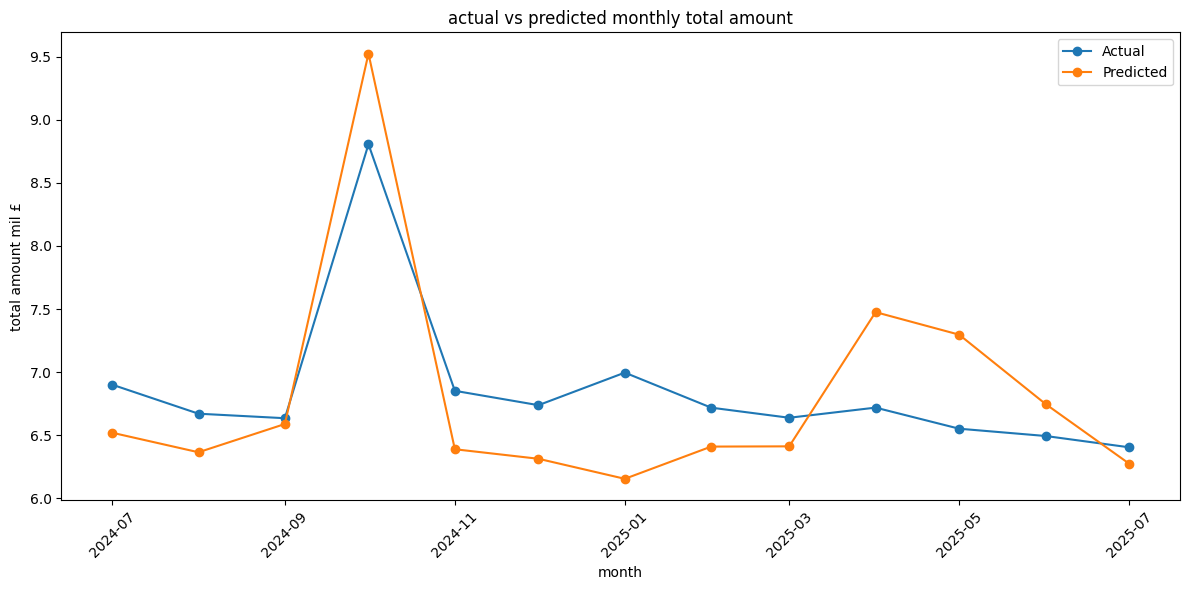

In [79]:

# plot monthly actual and predicted
plt.figure(figsize=(12, 6))
plt.plot(monthly_cmp['month_start'], monthly_cmp['amount'] / 1e6, marker='o', label='Actual')
plt.plot(monthly_cmp['month_start'], monthly_cmp['predicted_amount'] / 1e6, marker='o', label='Predicted')
plt.xlabel('month')
plt.ylabel('total amount mil £')
plt.title('actual vs predicted monthly total amount')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### forecast vs. budget

In [80]:

# budget spec for august 2025 to march 2026.
budget_spec = {
    'months': ['August', 'September', 'October', 'November', 'December', 'January', 'February', 'March'],
    'budget': [6819650.00, 9826859.00, 5453353.00, 5484053.00, 5463045.00, 5484052.00, 5473551.00, 5484530.00]
}
budgets_df = pd.DataFrame(budget_spec)


In [81]:

# map budget month names to month starts aligned to the forecast start
start_forecast = pd.to_datetime(future_monthly['month_start']).min()
month_to_num = {m: i for i, m in enumerate(calendar.month_name) if m}


In [82]:

# build a sequence of concrete month starts while rolling over year boundaries
assigned_dates = []
prev_ts = None
for name in budgets_df['months']:
    mnum = month_to_num[name]
    if prev_ts is None:
        year = start_forecast.year if mnum >= start_forecast.month else start_forecast.year + 1
        ts = pd.Timestamp(year, mnum, 1)
    else:
        year = prev_ts.year
        if mnum <= prev_ts.month:
            year += 1
        ts = pd.Timestamp(year, mnum, 1)
    assigned_dates.append(ts)
    prev_ts = ts

budgets_df['month_start'] = assigned_dates


In [83]:

# merge budgets with forecast totals and keep only budgeted months.
plot_df = budgets_df.merge(
    future_monthly[['month_start', 'predicted_total']],
    on='month_start',
    how='left'
).sort_values('month_start')

# drop any budget months that lie outside the forecast 
missing = plot_df['predicted_total'].isna().sum()
if missing:
    print(f"Warning: {missing} budget month(s) are outside the forecast horizon and will be excluded.")
    plot_df = plot_df.dropna(subset=['predicted_total'])




In [84]:

# variance metrics for each month.
y_label = 'Amount'
title_suffix = ''
plot_df['variance'] = plot_df['predicted_total'] - plot_df['budget']
plot_df['variance_%'] = 100 * plot_df['variance'] / plot_df['budget'].replace(0, pd.NA)



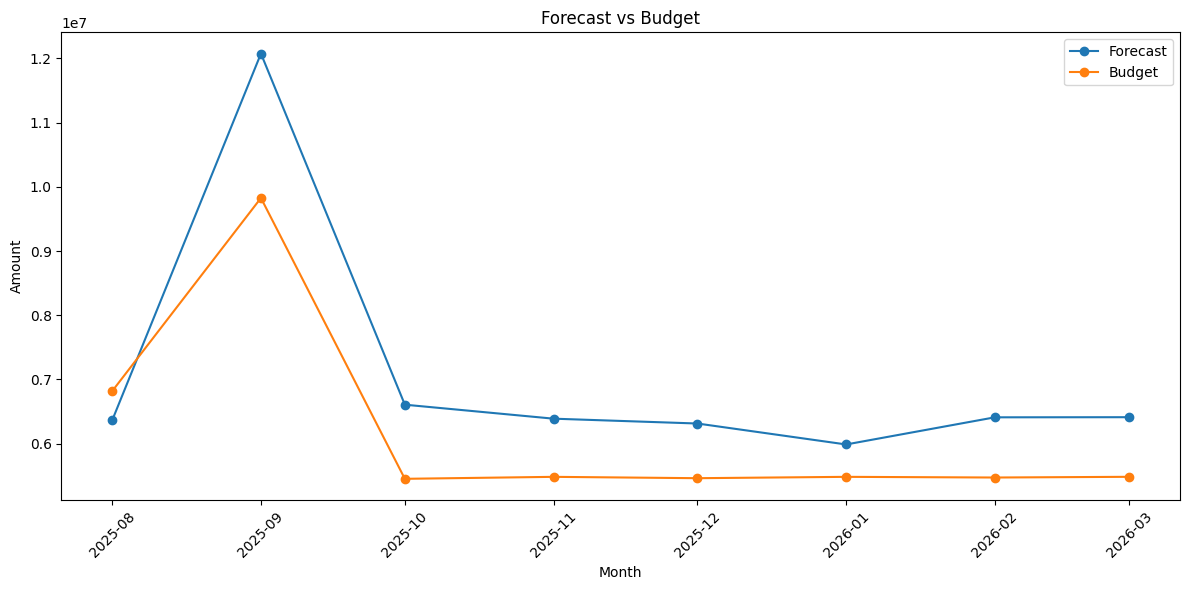


Forecast vs Budget variance:
month_start       budget  predicted_total     variance  variance_%
 2025-08-01 6,819,650.00     6,366,092.00  -453,558.00       -6.65
 2025-09-01 9,826,859.00    12,075,279.00 2,248,420.00       22.88
 2025-10-01 5,453,353.00     6,607,688.00 1,154,335.00       21.17
 2025-11-01 5,484,053.00     6,389,957.50   905,904.50       16.52
 2025-12-01 5,463,045.00     6,314,481.50   851,436.50       15.59
 2026-01-01 5,484,052.00     5,988,316.00   504,264.00        9.20
 2026-02-01 5,473,551.00     6,410,976.00   937,425.00       17.13
 2026-03-01 5,484,530.00     6,412,913.50   928,383.50       16.93


In [85]:

# plot forecast versus budget over the budget window
plt.figure(figsize=(12, 6))
plt.plot(plot_df['month_start'], plot_df['predicted_total'], marker='o', label='Forecast')
plt.plot(plot_df['month_start'], plot_df['budget'], marker='o', label='Budget')
plt.xlabel('Month')
plt.ylabel(y_label)
plt.title('Forecast vs Budget' + title_suffix)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# print a neat variance table for quick review.
out_cols = ['month_start', 'budget', 'predicted_total', 'variance', 'variance_%']
print("\nForecast vs Budget variance:")
print(plot_df[out_cols].to_string(index=False))


### Evaluation

**Evaluation Metrics**

- rmse:
root mean squared error.
tells how far off predictions are in the same units as the target.
large errors have a bigger effect because they are squared.

- mae:
mean absolute error;
shows the average size of the errors without caring if they are too high or too low.
easy to understand because it is in the same units as the data

- mape:
mean absolute percentage error.
shows the average error as a percent of the actual value.
useful for comparing across scales but can look very large if the actual values are small.

- r2:
coefficient of determination:
shows how much of the variation in the data is explained by the model.
values close to 1 mean the model explains most of the variation.
values near 0 mean the model is no better than guessing the mean.
negative values mean the model is worse than just predicting the mean


In [86]:
# try to import r2_score from sklearn if not available set it to none
#ugh
try:
    from sklearn.metrics import r2_score as _sk_r2
except Exception:
    _sk_r2 = None

# function to calculate root mean squared error
# this tells how far off predictions are in the same units as the target
def _rmse(y, yhat): 
    return float(np.sqrt(np.mean((y - yhat) ** 2)))

# function to calculate mean absolute error
# this gives the average size of the errors ignoring direction
def _mae(y, yhat):  
    return float(np.mean(np.abs(y - yhat)))

# function to calculate mean absolute percentage error
#this shows average error size as a percent of the actual values
#if actual values are close to zero it skips them to avoid division issues
def _mape(y, yhat, eps=1e-8):
    y, yhat = np.asarray(y, float), np.asarray(yhat, float)
    mask = np.abs(y) > eps
    if not np.any(mask): 
        return float(np.nan)
    return float(np.mean(np.abs((y[mask] - yhat[mask]) / y[mask])) * 100.0)

#function to calculate r2
#this measures how much of the variation in the data is explained by the model
#if sklearn is available it uses that otherwise it calculates manually
def _r2(y, yhat):
    y, yhat = np.asarray(y, float), np.asarray(yhat, float)
    if _sk_r2 is not None:
        return float(_sk_r2(y, yhat))
    ss_res, ss_tot = np.sum((y - yhat) ** 2), np.sum((y - np.mean(y)) ** 2)
    return float(1 - ss_res / ss_tot) if ss_tot > 0 else float(np.nan)

#main function to compute all metrics
#takes a dataframe and names of the actual and predicted columns
# can also group by colums like month or cost centre to get metrics per group
def evaluate_regression_metrics(df, actual_col, pred_col, group_cols=None):
    def _agg(grp):
        y, yhat = grp[actual_col].to_numpy(float), grp[pred_col].to_numpy(float)
        return pd.Series({
            'RMSE': _rmse(y,yhat),
            'MAE': _mae(y,yhat),
            'MAPE': _mape(y,yhat),
            'R2': _r2(y,yhat)
        })
    if group_cols:
        use_groups = [g for g in group_cols if g in df.columns]
        if not use_groups:
            return _agg(df).to_frame().T
        out = df.groupby(use_groups, dropna=False, as_index=False).apply(_agg).reset_index(drop=True)
        return out
    return _agg(df).to_frame().T

#two decimal places
pd.set_option("display.float_format", "{:,.2f}".format)

# calculate metrics at row level each row is a record in the test set
row_metrics = evaluate_regression_metrics(test_eval, actual_col="amount", pred_col="predicted_amount")
print("\nrow level metrics on test set")
print(row_metrics)

#calculate metrics at monthly totals level comparing actual and predicted monthly sums
month_metrics = evaluate_regression_metrics(monthly_cmp, actual_col="amount", pred_col="predicted_amount")
print("\nmonthly total metrics")
print(month_metrics)

#calculate metrics at cost centre by month level if cc column is present
if "cc" in test_eval.columns:
    cc_month_metrics = evaluate_regression_metrics(
        test_eval,
        actual_col="amount",
        pred_col="predicted_amount",
        group_cols=["cc","month_start"]
    )
    # show the first 20 rows so the printout is not too large
    print("\ncc by month metrics first 20 rows")
    print(cc_month_metrics.head(20))



row level metrics on test set
    RMSE    MAE     MAPE   R2
0 465.73 197.29 3,133.38 0.64

monthly total metrics
        RMSE        MAE  MAPE   R2
0 497,139.99 430,633.12  6.20 0.27


C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\vmerigli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



cc by month metrics first 20 rows
    cc month_start     RMSE    MAE   MAPE     R2
0    3  2024-07-01   296.42 172.49 104.73   0.93
1    3  2024-08-01   650.82 532.05 581.25   0.68
2    3  2024-09-01   244.08 188.81 164.23   0.95
3    3  2024-10-01   464.44 334.83 141.51   0.89
4    3  2024-11-01   299.41 190.17 113.02   0.94
5    3  2024-12-01   286.53 167.65  88.53   0.94
6    3  2025-01-01   289.07 199.67 131.68   0.94
7    3  2025-02-01   297.93 175.42  96.95   0.94
8    3  2025-03-01   277.90 164.54  97.64   0.94
9    3  2025-04-01   257.58 197.19  89.46   0.95
10   3  2025-05-01   300.04 221.62  95.49   0.93
11   3  2025-06-01   299.73 217.86  88.65   0.93
12   3  2025-07-01   278.17 207.09  89.53   0.94
13   4  2024-07-01 1,010.22 790.03  32.27   0.86
14   4  2024-08-01   958.32 723.48 588.30   0.82
15   4  2024-09-01 1,232.21 931.04  35.83   0.80
16   4  2024-10-01   591.17 590.98  49.50 -15.58
17   4  2024-11-01   902.82 662.51  70.25   0.88
18   4  2024-12-01   896.10 656.44

C:\Users\vmerigli\AppData\Local\Temp\ipykernel_3840\1273740169.py:54: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = df.groupby(use_groups, dropna=False, as_index=False).apply(_agg).reset_index(drop=True)


**Interpreting Results** 

interpretation of results:
- the model performs well on many cost centres with r2 values around 0.9 and errors that are stable month to month
- the model is weaker for some cost centres where r2 drops or goes negative and where percentage errors become very large
- these high percentage errors usually happen when the actual amounts are very small so even small absolute misses look big in percent terms

what the model is good at:
- it tracks overall spending patterns well
- it explains most of the variation in larger cost centres
- it gives a reliable baseline forecast at total and monthly levels

what the model is bad at:
- it struggles with small or volatile cost centres where actuals fluctuate or are near zero
- it sometimes gives forecasts that are worse than a simple average for these difficult cases
- it should be combined with business knowledge and adjustments for the more unusual cost centres


# Un-encoding and saving as CSV


In [ ]:
#helper to decode encoded values back into readable form
def decode_cc_and_budget(frame, inv_maps, drop_ohe=True, ohe_prefix='ijb_budget_page_'):
   
    #makes a copy of the dataframe
    #turns cc codes back into their original labels using the inverse mapping
    #turns budget page one hot encoded columns back into a single budget page column
  
    out = frame.copy()

    #decode cc if it exists in both the data and the inverse mapping
    if 'cc' in out.columns and 'cc' in inv_maps:
        #convert cc column to integers then map back to original codes
        cc_int = pd.to_numeric(out['cc'], errors='coerce').round().astype('Int64')
        out['cc'] = cc_int.map(inv_maps['cc'])

    #find all columns that start with the one hot prefix
    ohe_cols = [c for c in out.columns if c.startswith(ohe_prefix)]
    if ohe_cols:
        #calculate the sum per row to see if any one hot flags are set
        row_sums = out[ohe_cols].sum(axis=1)
        #find which column has the maximum value per row
        max_col = out[ohe_cols].idxmax(axis=1)
        #remove the prefix to get the original category name
        out['ijb_budget_page'] = np.where(
            row_sums.eq(0),
            pd.NA,
            max_col.str[len(ohe_prefix):]
        )

        #drop the one hot columns if requested
        if drop_ohe:
            out.drop(columns=ohe_cols, inplace=True)

    return out


Saving future detail df (all rows)

In [ ]:
# function to make csv files using unencoding elper above
#Rebuild human-readable columns then save every forecasted row.
future_detail_decoded = decode_cc_and_budget(future_detail, inv_mappings, drop_ohe=True)

#also decode other label-encoded cols
for col in ['payrollgroup', 'element', 'job']:
    if col in future_detail_decoded.columns and col in inv_mappings:
        tmp = pd.to_numeric(future_detail_decoded[col], errors='coerce').round().astype('Int64')
        future_detail_decoded[col] = tmp.map(inv_mappings[col])

# ensure clean date formatting
for dcol in ['date', 'month_start']:
    if dcol in future_detail_decoded.columns:
        future_detail_decoded[dcol] = pd.to_datetime(future_detail_decoded[dcol]).dt.strftime('%Y-%m-%d')

#save yayy
future_detail_path = 'forecast_detail_rows.csv'
future_detail_decoded.to_csv(future_detail_path, index=False)
print(f"Saved detailed forecast rows to: {future_detail_path}")



Saved detailed forecast rows to: forecast_detail_rows.csv


Saving monthly toatals df 

In [89]:

# Forecast of monthly totals
# You already computed `future_monthly` (with diagnostics). Keep it tidy and save.
future_monthly_out = future_monthly.copy()

# nice column names
future_monthly_out = future_monthly_out.rename(columns={'predicted_total': 'forecast_total'})

# date formatting
future_monthly_out['month_start'] = pd.to_datetime(future_monthly_out['month_start']).dt.strftime('%Y-%m-%d')

# choose what you want in the CSV (include diagnostics if useful)
monthly_cols = ['month_start', 'forecast_total', 'base_month', 'base_rowcount', 'future_rowcount', 'note']
monthly_cols = [c for c in monthly_cols if c in future_monthly_out.columns]
future_monthly_out = future_monthly_out[monthly_cols]

# save
future_monthly_path = 'forecast_monthly_totals.csv'
future_monthly_out.to_csv(future_monthly_path, index=False)
print(f"Saved monthly totals to: {future_monthly_path}")



Saved monthly totals to: forecast_monthly_totals.csv


Saving forecast vs budgets df 

In [90]:

#forecast vs budget
# `plot_df` already holds budget, forecast, and variances for the budgeted months.
budget_out = plot_df.copy()
budget_out = budget_out.rename(columns={'predicted_total': 'forecast_total'})
budget_out['month_start'] = pd.to_datetime(budget_out['month_start']).dt.strftime('%Y-%m-%d')

budget_cols = ['month_start', 'budget', 'forecast_total', 'variance', 'variance_%']
budget_cols = [c for c in budget_cols if c in budget_out.columns]
budget_out = budget_out[budget_cols]

# save
budget_csv_path = 'forecast_vs_budget.csv'
budget_out.to_csv(budget_csv_path, index=False)
print(f"Saved forecast vs budget to: {budget_csv_path}")


Saved forecast vs budget to: forecast_vs_budget.csv
